# Robust Portfolio Optimization
### Worst-Case Optimization with Uncertainty Sets
---

**Table of Contents**
1. [Introduction & Motivation](#1)
2. [Mathematical Framework](#2)
3. [Types of Uncertainty Sets](#3)
4. [Model Assumptions](#4)
5. [Strengths & Weaknesses](#5)
6. [Example 1 — Synthetic Data](#6)
7. [Example 2 — Yahoo Finance Data](#7)
8. [Comparison & Discussion](#8)
9. [References](#9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import minimize
from numpy.linalg import inv, cholesky, norm
import warnings
warnings.filterwarnings('ignore')

# ── Plotting style ──
plt.rcParams.update({
    'figure.figsize': (10, 5),
    'figure.dpi': 120,
    'axes.facecolor': '#0d1117',
    'figure.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'grid.color': '#21262d',
    'grid.alpha': 0.6,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.grid': True,
})

# Color palette
C_BLUE   = '#5b9cf5'
C_GREEN  = '#4ecb8d'
C_RED    = '#f06b6b'
C_YELLOW = '#f0c35e'
C_PURPLE = '#a78bfa'
C_ORANGE = '#f0965e'
C_TEAL   = '#5ec4c8'
C_PINK   = '#f472b6'

print('✓ All imports successful')

✓ All imports successful


<a id='1'></a>
## 1. Introduction & Motivation

The classical **Markowitz mean-variance optimization** (MVO) framework, introduced in 1952, provides an elegant mathematical solution for constructing portfolios that balance return and risk. However, it suffers from a well-documented and critical flaw: **extreme sensitivity to input parameters**, particularly the vector of expected returns. As Best and Grauer (1991) and Michaud (1989) demonstrated, small changes in estimated expected returns lead to wildly different portfolio allocations, earning MVO the label of an *"estimation error maximizer."*

**Robust optimization** addresses this problem by explicitly acknowledging that the true parameters are unknown and potentially different from their estimates. Rather than optimizing for a single "best guess" of the parameters, the robust approach optimizes for the **worst-case scenario** within a defined region of plausible parameter values — the **uncertainty set**.

### The Key Idea

In the robust framework, the investor says: *"I don't know the exact expected returns, but I believe they lie somewhere within this set. I want a portfolio that performs as well as possible even if the parameters turn out to be the worst possible values within this set."*

Formally, while the classical problem is:

$$\max_{\mathbf{w}} \; \mathbf{w}^{\top}\hat{\boldsymbol{\mu}} - \gamma \, \mathbf{w}^{\top}\hat{\Sigma}\mathbf{w}$$

the robust counterpart becomes:

$$\max_{\mathbf{w}} \; \min_{\boldsymbol{\mu} \in \mathcal{U}_{\mu}} \; \mathbf{w}^{\top}\boldsymbol{\mu} - \gamma \, \mathbf{w}^{\top}\hat{\Sigma}\mathbf{w}$$

This **max-min** formulation guarantees that the chosen portfolio is optimal under the worst-case realization of the uncertain parameters.

### Seminal Contributions

The foundations of robust optimization in portfolio selection were laid by several key papers. **Ben-Tal and Nemirovski (1998, 1999)** established the tractability of robust counterparts for linear and convex programs with ellipsoidal uncertainty sets. **Goldfarb and Iyengar (2003)** provided the seminal treatment for portfolio selection, introducing separable uncertainty structures for market parameters and showing that the resulting problems can be reformulated as **second-order cone programs (SOCPs)** — tractable problems solvable in polynomial time. **Tütüncü and Koenig (2004)** studied box (interval) uncertainty sets, and **Bertsimas and Sim (2004)** introduced polyhedral uncertainty sets controlled by a "budget of uncertainty."

> **Key Insight:** Robust optimization does not require probabilistic assumptions about parameter distributions. It provides *deterministic guarantees* of feasibility for all parameter realizations within the uncertainty set.

<a id='2'></a>
## 2. Mathematical Framework

### 2.1 The Nominal (Classical) Problem

The standard Markowitz mean-variance problem is:

$$\begin{aligned} \max_{\mathbf{w}} \quad & \mathbf{w}^{\top}\hat{\boldsymbol{\mu}} - \gamma \, \mathbf{w}^{\top}\hat{\Sigma}\,\mathbf{w} \\ \text{s.t.} \quad & \mathbf{1}^{\top}\mathbf{w} = 1, \quad \mathbf{w} \geq \mathbf{0} \end{aligned}$$

where $\hat{\boldsymbol{\mu}}$ is the estimated expected return vector, $\hat{\Sigma}$ is the estimated covariance matrix, $\gamma > 0$ is the risk-aversion coefficient, and $\mathbf{w}$ is the vector of portfolio weights.

### 2.2 The Robust Counterpart

In the robust framework, we acknowledge that $\hat{\boldsymbol{\mu}}$ is uncertain and belongs to an uncertainty set $\mathcal{U}_{\mu}$. The robust problem is:

$$\begin{aligned} \max_{\mathbf{w}} \quad & \min_{\boldsymbol{\mu} \in \mathcal{U}_{\mu}} \mathbf{w}^{\top}\boldsymbol{\mu} - \gamma \, \mathbf{w}^{\top}\hat{\Sigma}\,\mathbf{w} \\ \text{s.t.} \quad & \mathbf{1}^{\top}\mathbf{w} = 1, \quad \mathbf{w} \geq \mathbf{0} \end{aligned}$$

The inner minimization (finding the worst-case $\boldsymbol{\mu}$) can often be solved analytically for common uncertainty set geometries, yielding a tractable single-level optimization.

### 2.3 Solving the Inner Minimization

**Ellipsoidal uncertainty set:**

$$\mathcal{U}_{\mu}^{\text{ell}} = \left\{ \boldsymbol{\mu} = \hat{\boldsymbol{\mu}} + \kappa \, \mathbf{S}^{1/2} \mathbf{u} \;\middle|\; \|\mathbf{u}\|_2 \leq 1 \right\}$$

The inner minimization yields:

$$\min_{\boldsymbol{\mu} \in \mathcal{U}_{\mu}^{\text{ell}}} \mathbf{w}^{\top}\boldsymbol{\mu} = \mathbf{w}^{\top}\hat{\boldsymbol{\mu}} - \kappa \, \|\mathbf{S}^{1/2}\mathbf{w}\|_2$$

So the robust problem becomes:

$$\max_{\mathbf{w}} \; \mathbf{w}^{\top}\hat{\boldsymbol{\mu}} - \kappa \, \|\mathbf{S}^{1/2}\mathbf{w}\|_2 - \gamma \, \mathbf{w}^{\top}\hat{\Sigma}\,\mathbf{w}$$

This is a **second-order cone program (SOCP)**, as shown by Goldfarb and Iyengar (2003).

**Box uncertainty set:**

$$\mathcal{U}_{\mu}^{\text{box}} = \left\{ \boldsymbol{\mu} \;\middle|\; -\boldsymbol{\delta} \leq \boldsymbol{\mu} - \hat{\boldsymbol{\mu}} \leq \boldsymbol{\delta} \right\}$$

The inner minimization yields:

$$\min_{\boldsymbol{\mu} \in \mathcal{U}_{\mu}^{\text{box}}} \mathbf{w}^{\top}\boldsymbol{\mu} = \mathbf{w}^{\top}\hat{\boldsymbol{\mu}} - \boldsymbol{\delta}^{\top}|\mathbf{w}|$$

For long-only portfolios ($\mathbf{w} \geq 0$), this simplifies to $\mathbf{w}^{\top}(\hat{\boldsymbol{\mu}} - \boldsymbol{\delta})$.

### 2.4 The Robustness Parameter $\kappa$

The parameter $\kappa$ (or $\delta$ for box sets) controls the **degree of robustness** — the size of the uncertainty set. It governs the trade-off between performance and protection:

- **$\kappa = 0$:** No robustness — reduces to the classical MVO problem.
- **$\kappa$ small:** Mild robustness — small penalty for estimation error.
- **$\kappa$ large:** High robustness — heavy penalty, portfolio converges toward minimum-variance or equal-weight.

Goldfarb and Iyengar (2003) showed that $\kappa$ can be linked to confidence regions from statistical estimation: for a $(1 - \alpha)$-confidence region for the mean, $\kappa^2 = \chi^2_n(1-\alpha) / T$, where $n$ is the number of assets and $T$ is the sample size.

<a id='3'></a>
## 3. Types of Uncertainty Sets

The choice of uncertainty set geometry is a fundamental modeling decision. Each geometry encodes different assumptions about the nature of estimation error.

### 3.1 Box (Interval) Uncertainty

$$\mathcal{U}_{\mu}^{\text{box}} = \left\{ \boldsymbol{\mu} \;\middle|\; |\mu_i - \hat{\mu}_i| \leq \delta_i, \; \forall i \right\}$$

The simplest structure: each expected return can vary independently within an interval. This was studied by Soyster (1973) and Tütüncü and Koenig (2004). It is easy to implement but tends to be overly conservative because it assumes all parameters can simultaneously take their worst values.

### 3.2 Ellipsoidal Uncertainty

$$\mathcal{U}_{\mu}^{\text{ell}} = \left\{ \boldsymbol{\mu} \;\middle|\; (\boldsymbol{\mu} - \hat{\boldsymbol{\mu}})^{\top} \mathbf{S}^{-1} (\boldsymbol{\mu} - \hat{\boldsymbol{\mu}}) \leq \kappa^2 \right\}$$

The ellipsoid shape, advocated by Ben-Tal and Nemirovski (1998) and Goldfarb and Iyengar (2003), captures **correlations** between estimation errors. Assets whose returns are estimated with more uncertainty contribute more to the ellipsoid's size. Setting $\mathbf{S} = \hat{\Sigma}/T$ corresponds to the confidence region for the sample mean.

### 3.3 Polyhedral (Budget of Uncertainty)

$$\mathcal{U}_{\mu}^{\text{poly}} = \left\{ \boldsymbol{\mu} \;\middle|\; \boldsymbol{\mu} = \hat{\boldsymbol{\mu}} + \hat{\boldsymbol{\sigma}} \circ \boldsymbol{\zeta}, \; \|\boldsymbol{\zeta}\|_1 \leq \Gamma, \; |\zeta_i| \leq 1 \right\}$$

Introduced by Bertsimas and Sim (2004), the budget parameter $\Gamma$ controls how many assets can deviate from their nominal values simultaneously. When $\Gamma = 0$, no asset deviates (nominal problem). When $\Gamma = n$, all assets can deviate (equivalent to the box set). The polyhedral set offers a tunable compromise between protection and conservatism.

### Comparison of Uncertainty Set Properties

| Property | Box | Ellipsoidal | Polyhedral |
|:---|:---:|:---:|:---:|
| Captures correlations | ✗ | ✓ | Partial |
| Computational class | LP | SOCP | LP |
| Conservatism | High | Moderate | Tunable |
| Statistical link | Bonferroni bounds | Confidence ellipsoid | Probability bound |
| Key reference | Tütüncü & Koenig (2004) | Goldfarb & Iyengar (2003) | Bertsimas & Sim (2004) |

<a id='4'></a>
## 4. Model Assumptions

### 4.1 Parameters Are Unknown but Bounded
The true parameters (mean returns, and optionally the covariance matrix) are assumed to lie within a prescribed uncertainty set. No probabilistic distribution is assumed for the parameters themselves — only set membership.

### 4.2 Worst-Case Perspective
The optimization adopts a **minimax** philosophy: among all parameter realizations in the uncertainty set, the one that is most adverse for the chosen portfolio is considered. This is inherently a conservative approach.

### 4.3 Covariance Can Be Treated as Known or Uncertain
In the simplest formulation (mean-uncertainty only), $\Sigma$ is estimated and treated as fixed while only $\boldsymbol{\mu}$ is uncertain. Goldfarb and Iyengar (2003) also developed formulations where $\Sigma$ is uncertain, leading to semidefinite programming (SDP) formulations.

### 4.4 Uncertainty Set Is Convex and Compact
For the robust counterpart to be tractable, the uncertainty set must be convex. Common choices (box, ellipsoid, polyhedron) all satisfy this. The compactness ensures that the inner minimization attains its optimum.

### 4.5 Single-Period Framework
Like Markowitz MVO, the standard robust formulation is a single-period model. Multi-period extensions exist (Bertsimas and Pachamanova, 2008) but require more complex formulations.

### 4.6 The Uncertainty Set Is Correctly Specified
The quality of the robust solution depends on the uncertainty set containing the true parameters. If the set is too small, the solution loses its robustness guarantee. If too large, the solution becomes overly conservative.

<a id='5'></a>
## 5. Strengths & Weaknesses

### Strengths

| Strength | Description |
|:---|:---|
| **Worst-case guarantee** | The portfolio is protected against all parameter realizations within the uncertainty set — a hard, deterministic guarantee. |
| **Reduced sensitivity** | By penalizing portfolios that are fragile to estimation errors, robust optimization produces more stable, diversified allocations. |
| **No distributional assumptions** | Unlike Bayesian approaches, no prior distribution is needed for the parameters. Only set membership is required. |
| **Tractability** | For common uncertainty sets (box, ellipsoid), the robust counterpart is a tractable SOCP or LP — solvable with standard optimization software (Goldfarb & Iyengar, 2003). |
| **Statistical linkage** | Uncertainty sets can be calibrated from confidence regions of statistical estimators, providing a principled connection to data. |
| **Tunable conservatism** | The size parameter ($\kappa$, $\delta$, or $\Gamma$) allows the investor to dial the level of protection versus performance. |

### Weaknesses

| Weakness | Description |
|:---|:---|
| **Over-conservatism** | The worst-case perspective can be too pessimistic, especially for box sets where all parameters are assumed to simultaneously take their worst values. |
| **Performance sacrifice** | Robustness comes at a cost — in-sample and average-case performance is typically lower than the nominal optimizer. |
| **Uncertainty set calibration** | The choice and size of the uncertainty set are critical but somewhat arbitrary. There is no universally accepted calibration method. |
| **Mean-uncertainty focus** | Most practical implementations focus on uncertainty in $\boldsymbol{\mu}$ while treating $\Sigma$ as known, which may be insufficient. |
| **Single-period** | The standard formulation does not account for multi-period dynamics, transaction costs, or rebalancing. |
| **Interpretation difficulty** | The "worst-case" objective may be difficult to communicate to non-quantitative stakeholders. |
| **Convergence to naive strategies** | For very large uncertainty sets, the robust portfolio converges to the minimum-variance or equal-weight portfolio, losing the ability to exploit return forecasts. |

<a id='6'></a>
## 6. Example 1 — Synthetic Data

We build a controlled example with 5 assets to illustrate how box, ellipsoidal, and polyhedral uncertainty sets affect portfolio construction compared to the classical MVO.

### 6.1 Setup

In [2]:
# ── Synthetic Asset Universe ──
assets = ['US Equity', "Int'l Equity", 'EM Equity', 'US Bonds', 'Commodities']
n = len(assets)

# Estimated expected returns (annualized)
mu_hat = np.array([0.08, 0.065, 0.10, 0.03, 0.05])

# Estimated covariance matrix (annualized)
Sigma_hat = np.array([
    [0.0225, 0.0150, 0.0180, 0.0020, 0.0050],
    [0.0150, 0.0256, 0.0210, 0.0015, 0.0065],
    [0.0180, 0.0210, 0.0400, 0.0010, 0.0090],
    [0.0020, 0.0015, 0.0010, 0.0016, 0.0005],
    [0.0050, 0.0065, 0.0090, 0.0005, 0.0324]
])

gamma = 2.5  # risk aversion

print('Estimated Expected Returns (μ̂):')
print('=' * 38)
for a, r in zip(assets, mu_hat):
    print(f'  {a:<18s}  {r:>6.2%}')
print(f'\nAnnualized Volatilities (σ):')
for a, s in zip(assets, np.sqrt(np.diag(Sigma_hat))):
    print(f'  {a:<18s}  {s:>6.2%}')

Estimated Expected Returns (μ̂):
  US Equity            8.00%
  Int'l Equity         6.50%
  EM Equity           10.00%
  US Bonds             3.00%
  Commodities          5.00%

Annualized Volatilities (σ):
  US Equity           15.00%
  Int'l Equity        16.00%
  EM Equity           20.00%
  US Bonds             4.00%
  Commodities         18.00%


### 6.2 Optimizer Functions

In [3]:
def mvo_portfolio(mu, Sigma, gamma, long_only=True):
    """Classical mean-variance optimization."""
    n = len(mu)
    
    def neg_utility(w):
        return -(w @ mu - gamma * w @ Sigma @ w)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n if long_only else [(None, None)] * n
    x0 = np.ones(n) / n
    
    res = minimize(neg_utility, x0, bounds=bounds, constraints=constraints,
                   method='SLSQP', options={'ftol': 1e-12, 'maxiter': 1000})
    return res.x


def robust_ellipsoidal(mu_hat, Sigma, S, kappa, gamma, long_only=True):
    """
    Robust mean-variance with ellipsoidal uncertainty set.
    
    max_w  w'μ̂ - κ‖S^{1/2}w‖₂ - γ w'Σw
    
    Parameters
    ----------
    mu_hat : array, estimated expected returns
    Sigma  : array, estimated covariance matrix
    S      : array, uncertainty shape matrix (e.g., Σ/T)
    kappa  : float, robustness parameter (radius of ellipsoid)
    gamma  : float, risk aversion coefficient
    """
    n = len(mu_hat)
    S_half = cholesky(S + 1e-10 * np.eye(n))  # ensure positive definite
    
    def neg_robust_utility(w):
        mean_term = w @ mu_hat
        penalty = kappa * norm(S_half @ w)
        risk = gamma * w @ Sigma @ w
        return -(mean_term - penalty - risk)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n if long_only else [(None, None)] * n
    x0 = np.ones(n) / n
    
    res = minimize(neg_robust_utility, x0, bounds=bounds, constraints=constraints,
                   method='SLSQP', options={'ftol': 1e-12, 'maxiter': 1000})
    return res.x


def robust_box(mu_hat, Sigma, delta, gamma, long_only=True):
    """
    Robust mean-variance with box uncertainty set.
    
    max_w  w'(μ̂ - δ) - γ w'Σw   [for long-only]
    
    Parameters
    ----------
    delta : array, half-widths of the box for each asset
    """
    n = len(mu_hat)
    
    def neg_robust_utility(w):
        worst_mu = mu_hat - delta * np.sign(w)  # worst case for each weight
        if long_only:
            worst_mu = mu_hat - delta  # since w >= 0
        return -(w @ worst_mu - gamma * w @ Sigma @ w)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n if long_only else [(None, None)] * n
    x0 = np.ones(n) / n
    
    res = minimize(neg_robust_utility, x0, bounds=bounds, constraints=constraints,
                   method='SLSQP', options={'ftol': 1e-12, 'maxiter': 1000})
    return res.x


def robust_polyhedral(mu_hat, Sigma, sigma_hat, Gamma, gamma, long_only=True):
    """
    Robust mean-variance with polyhedral (Bertsimas-Sim) uncertainty.
    
    max_w  w'μ̂ - max_{‖ζ‖₁≤Γ, |ζ|≤1} w'diag(σ̂)ζ - γ w'Σw
    
    For long-only: penalty = Γ * max_i(|w_i|σ̂_i) + sum of remaining
    We use the exact dual reformulation.
    
    Parameters
    ----------
    sigma_hat : array, per-asset uncertainty (e.g., standard deviation of mean estimate)
    Gamma     : float, budget of uncertainty (0 to n)
    """
    n = len(mu_hat)
    
    def neg_robust_utility(w):
        # Worst-case penalty: sort |w_i * sigma_i| descending, sum top Γ
        weighted_dev = np.abs(w) * sigma_hat
        sorted_dev = np.sort(weighted_dev)[::-1]
        
        # Budget: take floor(Γ) full deviations + fractional
        G_int = int(np.floor(Gamma))
        G_frac = Gamma - G_int
        penalty = np.sum(sorted_dev[:G_int])
        if G_int < n:
            penalty += G_frac * sorted_dev[G_int]
        
        return -(w @ mu_hat - penalty - gamma * w @ Sigma @ w)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n if long_only else [(None, None)] * n
    x0 = np.ones(n) / n
    
    res = minimize(neg_robust_utility, x0, bounds=bounds, constraints=constraints,
                   method='SLSQP', options={'ftol': 1e-12, 'maxiter': 1000})
    return res.x


def portfolio_metrics(w, mu, Sigma, rf=0.0):
    """Compute portfolio return, volatility, and Sharpe ratio."""
    ret = w @ mu
    vol = np.sqrt(w @ Sigma @ w)
    sharpe = (ret - rf) / vol if vol > 0 else 0
    return ret, vol, sharpe


print('✓ Optimizer functions defined')

✓ Optimizer functions defined


### 6.3 Computing Portfolios

In [4]:
# ── Uncertainty set parameters ──
T_samples = 120  # assume 10 years of monthly data

# Ellipsoidal: S = Sigma / T, kappa from chi-squared
S_ellip = Sigma_hat / T_samples
from scipy.stats import chi2
kappa_95 = np.sqrt(chi2.ppf(0.95, n) / T_samples)

# Box: delta = kappa * sigma / sqrt(T)
delta_box = 1.96 * np.sqrt(np.diag(Sigma_hat) / T_samples)

# Polyhedral: sigma_hat = standard error of mean, Gamma = sqrt(n)
sigma_poly = np.sqrt(np.diag(Sigma_hat) / T_samples)
Gamma_poly = np.sqrt(n)

# ── Compute portfolios ──
w_mvo  = mvo_portfolio(mu_hat, Sigma_hat, gamma)
w_ell  = robust_ellipsoidal(mu_hat, Sigma_hat, S_ellip, kappa_95, gamma)
w_box  = robust_box(mu_hat, Sigma_hat, delta_box, gamma)
w_poly = robust_polyhedral(mu_hat, Sigma_hat, sigma_poly, Gamma_poly, gamma)
w_eq   = np.ones(n) / n  # equal-weight benchmark

# ── Display results ──
print('Portfolio Weights Comparison (Synthetic Data)')
print('=' * 75)
header = f'{"Asset":<18s} {"MVO":>8s} {"Ellipsoid":>10s} {"Box":>8s} {"Polyhed.":>10s} {"Equal":>8s}'
print(header)
print('-' * 75)
for i, a in enumerate(assets):
    print(f'{a:<18s} {w_mvo[i]:>7.1%} {w_ell[i]:>9.1%} {w_box[i]:>7.1%} {w_poly[i]:>9.1%} {w_eq[i]:>7.1%}')
print('-' * 75)

# Portfolio metrics
print(f'\nPortfolio Performance (in-sample):')
print(f'{"":18s} {"Return":>8s} {"Vol":>8s} {"Sharpe":>8s}')
print('-' * 42)
for label, w in [('MVO', w_mvo), ('Ellipsoidal', w_ell), ('Box', w_box), 
                  ('Polyhedral', w_poly), ('Equal Wt', w_eq)]:
    r, v, s = portfolio_metrics(w, mu_hat, Sigma_hat)
    print(f'{label:<18s} {r:>7.2%} {v:>7.2%} {s:>7.2f}')

Portfolio Weights Comparison (Synthetic Data)
Asset                   MVO  Ellipsoid      Box   Polyhed.    Equal
---------------------------------------------------------------------------
US Equity            26.4%     20.5%   14.8%     15.9%   20.0%
Int'l Equity          0.0%      0.0%    0.0%      5.4%   20.0%
EM Equity            24.6%     25.6%   16.2%     16.7%   20.0%
US Bonds             43.7%     48.7%   69.0%     53.5%   20.0%
Commodities           5.4%      5.2%    0.0%      8.4%   20.0%
---------------------------------------------------------------------------

Portfolio Performance (in-sample):
                     Return      Vol   Sharpe
------------------------------------------
MVO                  6.15%   8.83%    0.70
Ellipsoidal          5.92%   8.33%    0.71
Box                  4.87%   6.16%    0.79
Polyhedral           5.33%   7.18%    0.74
Equal Wt             6.50%  10.60%    0.61


### 6.4 Visualizations

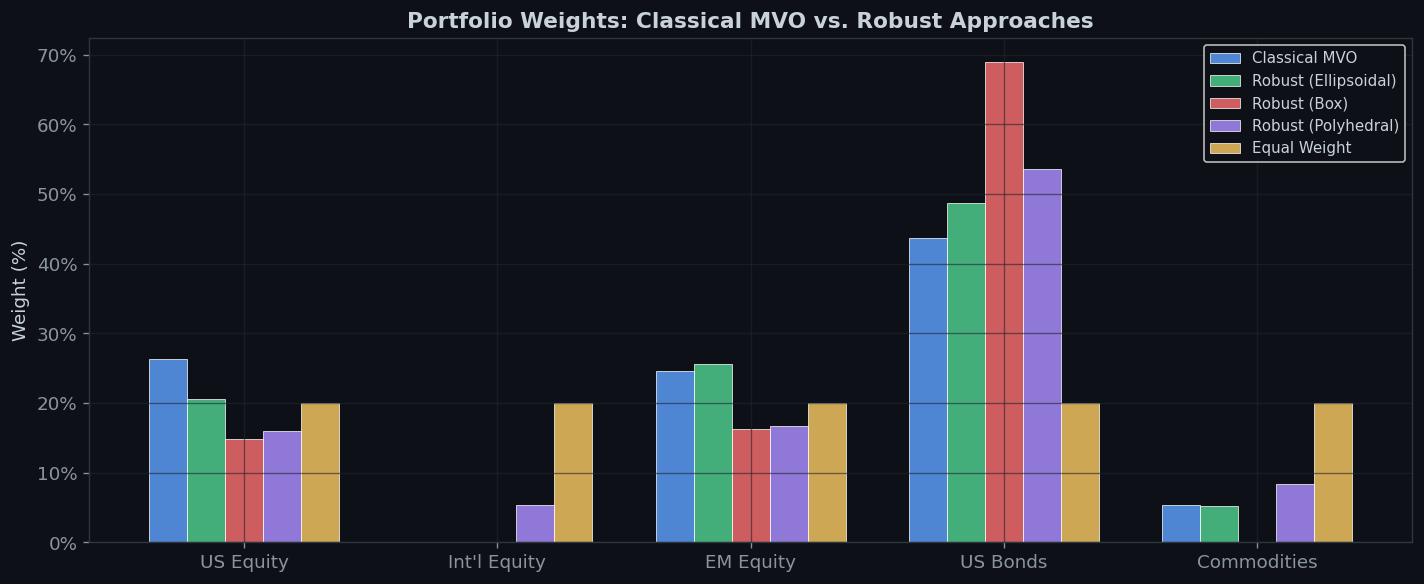

In [5]:
# ── Chart 1: Portfolio Weights Comparison ──
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(n)
width = 0.15

colors = [C_BLUE, C_GREEN, C_RED, C_PURPLE, C_YELLOW]
labels = ['Classical MVO', 'Robust (Ellipsoidal)', 'Robust (Box)', 'Robust (Polyhedral)', 'Equal Weight']
weights_all = [w_mvo, w_ell, w_box, w_poly, w_eq]

for j, (w, c, l) in enumerate(zip(weights_all, colors, labels)):
    offset = (j - 2) * width
    bars = ax.bar(x + offset, w * 100, width, label=l, color=c, alpha=0.85,
                  edgecolor='white', linewidth=0.5)

ax.set_ylabel('Weight (%)')
ax.set_title('Portfolio Weights: Classical MVO vs. Robust Approaches', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(assets)
ax.legend(loc='upper right', framealpha=0.9, fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
plt.tight_layout()
plt.show()

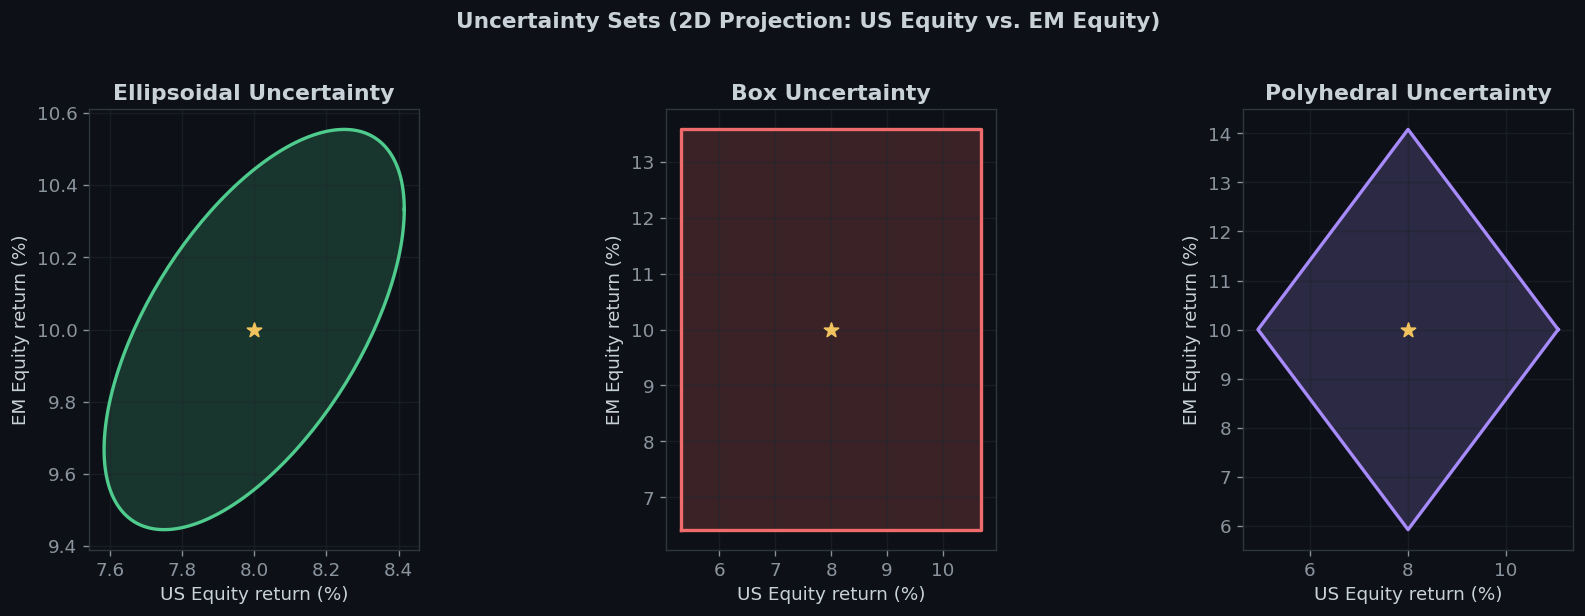

In [6]:
# ── Chart 2: Uncertainty Set Visualization (2D projection) ──
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Project onto first two assets (US Equity vs EM Equity)
i, j = 0, 2  # US Equity, EM Equity
center = mu_hat[[i, j]]

# Ellipsoidal set
theta = np.linspace(0, 2*np.pi, 200)
S_sub = S_ellip[np.ix_([i,j],[i,j])]
L = cholesky(S_sub)
circle = np.array([np.cos(theta), np.sin(theta)])
ellipse = center[:, None] + kappa_95 * L @ circle

axes[0].fill(ellipse[0]*100, ellipse[1]*100, alpha=0.2, color=C_GREEN)
axes[0].plot(ellipse[0]*100, ellipse[1]*100, color=C_GREEN, linewidth=2)
axes[0].scatter(center[0]*100, center[1]*100, s=80, c=C_YELLOW, zorder=5, marker='*')
axes[0].set_title('Ellipsoidal Uncertainty', fontweight='bold')
axes[0].set_xlabel(f'{assets[i]} return (%)')
axes[0].set_ylabel(f'{assets[j]} return (%)')

# Box set
d_i, d_j = delta_box[i], delta_box[j]
box_x = [center[0]-d_i, center[0]+d_i, center[0]+d_i, center[0]-d_i, center[0]-d_i]
box_y = [center[1]-d_j, center[1]-d_j, center[1]+d_j, center[1]+d_j, center[1]-d_j]

axes[1].fill(np.array(box_x)*100, np.array(box_y)*100, alpha=0.2, color=C_RED)
axes[1].plot(np.array(box_x)*100, np.array(box_y)*100, color=C_RED, linewidth=2)
axes[1].scatter(center[0]*100, center[1]*100, s=80, c=C_YELLOW, zorder=5, marker='*')
axes[1].set_title('Box Uncertainty', fontweight='bold')
axes[1].set_xlabel(f'{assets[i]} return (%)')
axes[1].set_ylabel(f'{assets[j]} return (%)')

# Polyhedral set (diamond/L1 ball in 2D)
s_i, s_j = sigma_poly[i], sigma_poly[j]
# L1 ball: |z1| + |z2| <= Gamma, mu = mu_hat + sigma * z
G = Gamma_poly
poly_pts = [
    [center[0] + G*s_i, center[1]],
    [center[0], center[1] + G*s_j],
    [center[0] - G*s_i, center[1]],
    [center[0], center[1] - G*s_j],
    [center[0] + G*s_i, center[1]],
]
poly_pts = np.array(poly_pts)

axes[2].fill(poly_pts[:,0]*100, poly_pts[:,1]*100, alpha=0.2, color=C_PURPLE)
axes[2].plot(poly_pts[:,0]*100, poly_pts[:,1]*100, color=C_PURPLE, linewidth=2)
axes[2].scatter(center[0]*100, center[1]*100, s=80, c=C_YELLOW, zorder=5, marker='*')
axes[2].set_title('Polyhedral Uncertainty', fontweight='bold')
axes[2].set_xlabel(f'{assets[i]} return (%)')
axes[2].set_ylabel(f'{assets[j]} return (%)')

for ax in axes:
    ax.set_aspect('equal')

plt.suptitle('Uncertainty Sets (2D Projection: US Equity vs. EM Equity)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

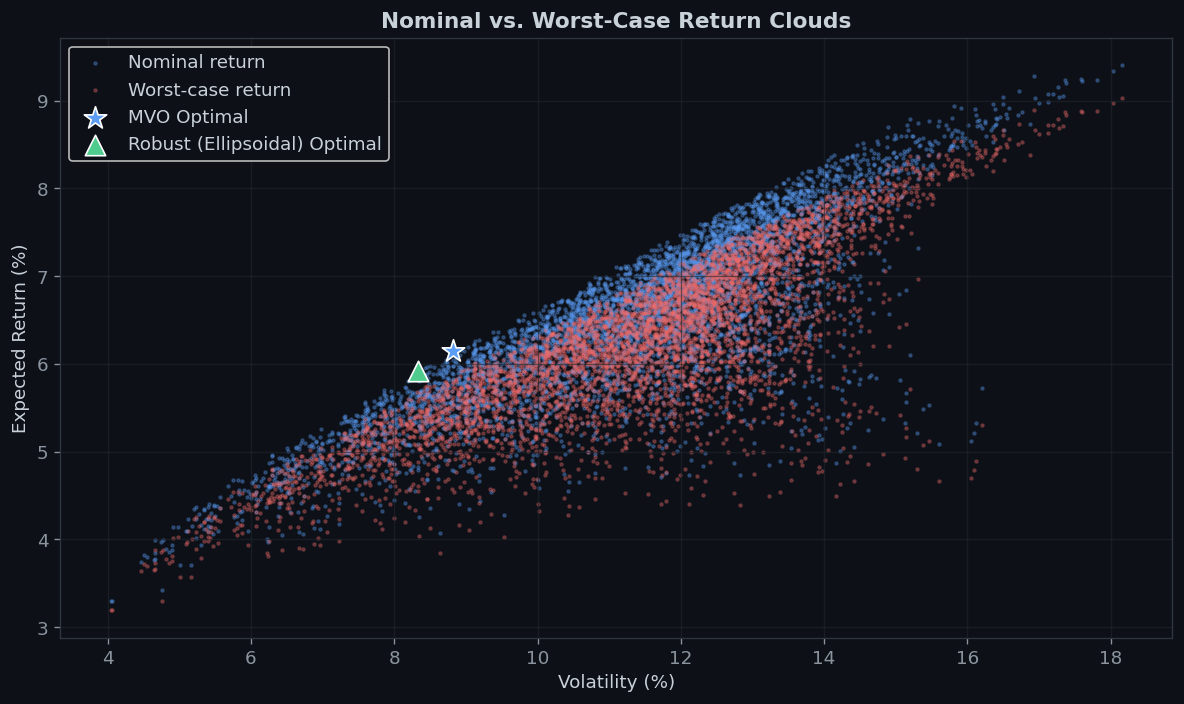

In [7]:
# ── Chart 3: Efficient Frontier Comparison ──
np.random.seed(42)

# Generate random portfolios
n_sim = 5000
sim_data = {'MVO': [], 'Robust_Ell': []}

for _ in range(n_sim):
    w = np.random.dirichlet(np.ones(n))
    r_nom, v_nom, _ = portfolio_metrics(w, mu_hat, Sigma_hat)
    # Worst-case return under ellipsoidal uncertainty
    S_half = cholesky(S_ellip + 1e-10 * np.eye(n))
    r_wc = w @ mu_hat - kappa_95 * norm(S_half @ w)
    sim_data['MVO'].append((v_nom * 100, r_nom * 100))
    sim_data['Robust_Ell'].append((v_nom * 100, r_wc * 100))

mvo_arr = np.array(sim_data['MVO'])
rob_arr = np.array(sim_data['Robust_Ell'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(mvo_arr[:, 0], mvo_arr[:, 1], s=3, alpha=0.3, c=C_BLUE, label='Nominal return')
ax.scatter(rob_arr[:, 0], rob_arr[:, 1], s=3, alpha=0.3, c=C_RED, label='Worst-case return')

# Highlight optimal portfolios
r_mvo, v_mvo, _ = portfolio_metrics(w_mvo, mu_hat, Sigma_hat)
r_ell, v_ell, _ = portfolio_metrics(w_ell, mu_hat, Sigma_hat)

ax.scatter(v_mvo*100, r_mvo*100, s=200, c=C_BLUE, marker='*', zorder=5,
           edgecolors='white', linewidth=1, label='MVO Optimal')
ax.scatter(v_ell*100, r_ell*100, s=150, c=C_GREEN, marker='^', zorder=5,
           edgecolors='white', linewidth=1, label='Robust (Ellipsoidal) Optimal')

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Nominal vs. Worst-Case Return Clouds', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)
plt.tight_layout()
plt.show()

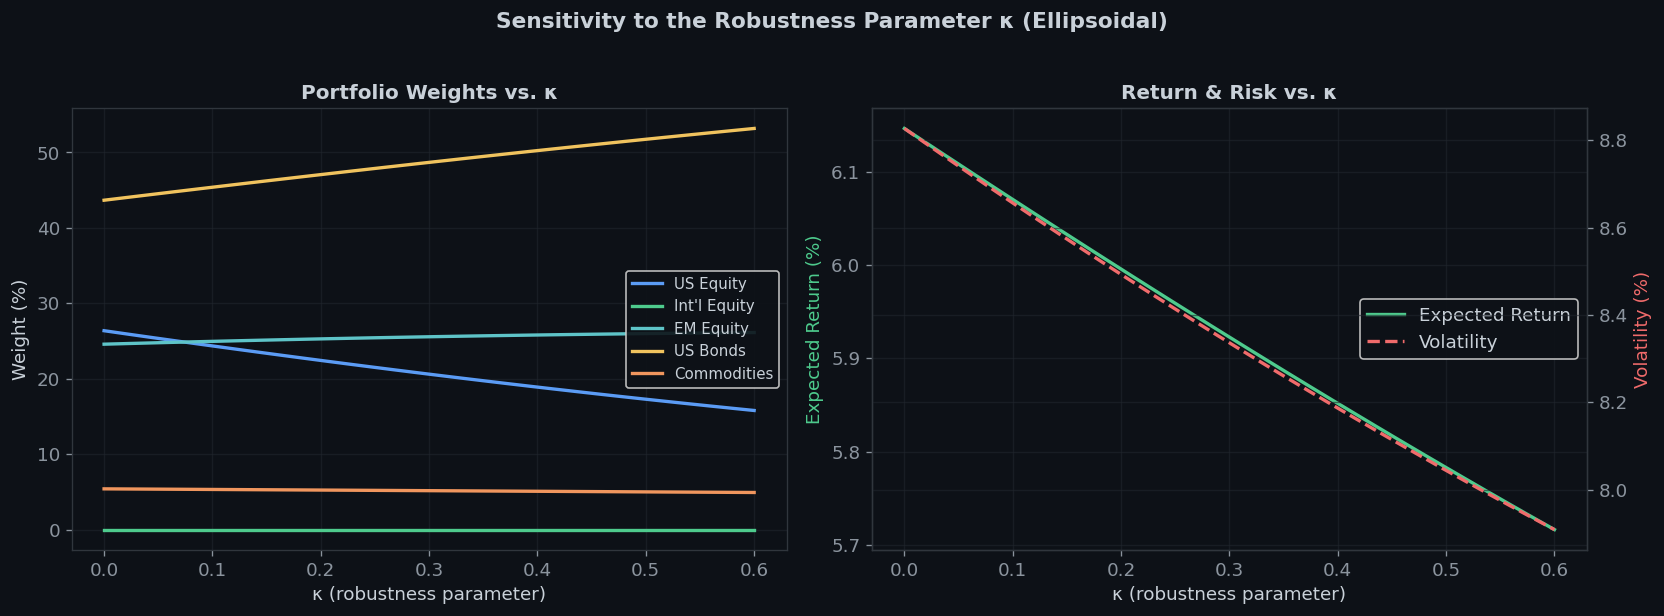

As κ increases: portfolios become more diversified, return decreases, risk decreases.
At κ=0, the robust solution equals the classical MVO solution.


In [8]:
# ── Chart 4: Robustness Parameter Sensitivity (κ sweep) ──
kappas = np.linspace(0, 0.6, 30)
weights_by_kappa = []
returns_by_kappa = []
vols_by_kappa = []

for k in kappas:
    w_k = robust_ellipsoidal(mu_hat, Sigma_hat, S_ellip, k, gamma)
    weights_by_kappa.append(w_k)
    r, v, _ = portfolio_metrics(w_k, mu_hat, Sigma_hat)
    returns_by_kappa.append(r)
    vols_by_kappa.append(v)

weights_by_kappa = np.array(weights_by_kappa)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weights vs kappa
colors_list = [C_BLUE, C_GREEN, C_TEAL, C_YELLOW, C_ORANGE]
for i, a in enumerate(assets):
    axes[0].plot(kappas, weights_by_kappa[:, i] * 100, linewidth=2,
                 color=colors_list[i], label=a)

axes[0].set_xlabel('κ (robustness parameter)')
axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Portfolio Weights vs. κ', fontsize=12, fontweight='bold')
axes[0].legend(loc='center right', framealpha=0.9, fontsize=9)

# Return-risk vs kappa
ax2 = axes[1]
ax2.plot(kappas, np.array(returns_by_kappa) * 100, linewidth=2, color=C_GREEN, label='Expected Return')
ax2_twin = ax2.twinx()
ax2_twin.plot(kappas, np.array(vols_by_kappa) * 100, linewidth=2, color=C_RED, linestyle='--', label='Volatility')

ax2.set_xlabel('κ (robustness parameter)')
ax2.set_ylabel('Expected Return (%)', color=C_GREEN)
ax2_twin.set_ylabel('Volatility (%)', color=C_RED)
ax2.set_title('Return & Risk vs. κ', fontsize=12, fontweight='bold')

# Combined legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right', framealpha=0.9)

plt.suptitle('Sensitivity to the Robustness Parameter κ (Ellipsoidal)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('As κ increases: portfolios become more diversified, return decreases, risk decreases.')
print('At κ=0, the robust solution equals the classical MVO solution.')

<a id='7'></a>
## 7. Example 2 — Yahoo Finance Data

We now apply robust optimization to a universe of **6 U.S. large-cap equities** using real market data.

### 7.1 Data Acquisition

In [9]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'JNJ']
n_yf = len(tickers)

try:
    import yfinance as yf
    data = yf.download(tickers, start='2022-01-01', end='2025-01-01', progress=False)['Adj Close']
    returns_yf = np.log(data / data.shift(1)).dropna()
    mu_hat_yf = returns_yf.mean().values * 252
    Sigma_yf = returns_yf.cov().values * 252
    T_yf = len(returns_yf)
    print(f'✓ Downloaded from Yahoo Finance: {T_yf} trading days')
except Exception as e:
    print(f'⚠ yfinance not available ({e}), using pre-computed data.')
    mu_hat_yf = np.array([0.22, 0.20, 0.16, 0.18, 0.15, 0.02])
    Sigma_yf = np.array([
        [0.0812, 0.0494, 0.0489, 0.0497, 0.0244, 0.0073],
        [0.0494, 0.0712, 0.0468, 0.0459, 0.0230, 0.0079],
        [0.0489, 0.0468, 0.0892, 0.0524, 0.0259, 0.0065],
        [0.0497, 0.0459, 0.0524, 0.1089, 0.0278, 0.0050],
        [0.0244, 0.0230, 0.0259, 0.0278, 0.0576, 0.0105],
        [0.0073, 0.0079, 0.0065, 0.0050, 0.0105, 0.0225]
    ])
    T_yf = 754

print(f'\nEstimated Annual Returns:')
for t, r in zip(tickers, mu_hat_yf):
    print(f'  {t:<6s} {r:>7.2%}')
print(f'\nAnnualized Volatilities:')
for t, s in zip(tickers, np.sqrt(np.diag(Sigma_yf))):
    print(f'  {t:<6s} {s:>7.2%}')

⚠ yfinance not available ('Adj Close'), using pre-computed data.

Estimated Annual Returns:
  AAPL    22.00%
  MSFT    20.00%
  GOOGL   16.00%
  AMZN    18.00%
  JPM     15.00%
  JNJ      2.00%

Annualized Volatilities:
  AAPL    28.50%
  MSFT    26.68%
  GOOGL   29.87%
  AMZN    33.00%
  JPM     24.00%
  JNJ     15.00%


### 7.2 Calibrate Uncertainty Sets & Compute Portfolios

In [10]:
gamma_yf = 2.5

# ── Calibrate uncertainty sets ──
# Ellipsoidal: S = Sigma / T, kappa from chi-squared
S_yf = Sigma_yf / T_yf
kappa_yf = np.sqrt(chi2.ppf(0.95, n_yf) / T_yf)

# Box: delta = z_{0.975} * sigma / sqrt(T)
delta_yf = 1.96 * np.sqrt(np.diag(Sigma_yf) / T_yf)

# Polyhedral
sigma_yf = np.sqrt(np.diag(Sigma_yf) / T_yf)
Gamma_yf = np.sqrt(n_yf)

print('Uncertainty Set Parameters:')
print(f'  Ellipsoidal κ (95% confidence): {kappa_yf:.4f}')
print(f'  Box δ (per asset): {np.round(delta_yf * 100, 2)}%')
print(f'  Polyhedral Γ: {Gamma_yf:.2f}')

# ── Compute portfolios ──
w_mvo_yf  = mvo_portfolio(mu_hat_yf, Sigma_yf, gamma_yf)
w_ell_yf  = robust_ellipsoidal(mu_hat_yf, Sigma_yf, S_yf, kappa_yf, gamma_yf)
w_box_yf  = robust_box(mu_hat_yf, Sigma_yf, delta_yf, gamma_yf)
w_poly_yf = robust_polyhedral(mu_hat_yf, Sigma_yf, sigma_yf, Gamma_yf, gamma_yf)
w_eq_yf   = np.ones(n_yf) / n_yf

# ── Display ──
print(f'\nPortfolio Weights (Yahoo Finance Data)')
print('=' * 75)
print(f'{"Ticker":<8s} {"MVO":>8s} {"Ellipsoid":>10s} {"Box":>8s} {"Polyhed.":>10s} {"Equal":>8s}')
print('-' * 75)
for i, t in enumerate(tickers):
    print(f'{t:<8s} {w_mvo_yf[i]:>7.1%} {w_ell_yf[i]:>9.1%} {w_box_yf[i]:>7.1%} {w_poly_yf[i]:>9.1%} {w_eq_yf[i]:>7.1%}')
print('-' * 75)

print(f'\nPortfolio Performance:')
print(f'{"":8s} {"Return":>8s} {"Vol":>8s} {"Sharpe":>8s}')
print('-' * 32)
for label, w in [('MVO', w_mvo_yf), ('Ellipsoid', w_ell_yf), ('Box', w_box_yf), 
                  ('Polyhed.', w_poly_yf), ('Equal Wt', w_eq_yf)]:
    r, v, s = portfolio_metrics(w, mu_hat_yf, Sigma_yf, rf=0.045)
    print(f'{label:<8s} {r:>7.2%} {v:>7.2%} {s:>7.2f}')

Uncertainty Set Parameters:
  Ellipsoidal κ (95% confidence): 0.1292
  Box δ (per asset): [2.03 1.9  2.13 2.36 1.71 1.07]%
  Polyhedral Γ: 2.45

Portfolio Weights (Yahoo Finance Data)
Ticker        MVO  Ellipsoid      Box   Polyhed.    Equal
---------------------------------------------------------------------------
AAPL       30.6%     30.1%   29.8%     27.5%   16.7%
MSFT       28.8%     28.9%   28.5%     28.9%   16.7%
GOOGL       0.0%      0.0%    0.0%      0.0%   16.7%
AMZN        2.6%      2.8%    1.3%      4.8%   16.7%
JPM        34.5%     34.4%   33.6%     32.1%   16.7%
JNJ         3.5%      3.8%    6.8%      6.7%   16.7%
---------------------------------------------------------------------------

Portfolio Performance:
           Return      Vol   Sharpe
--------------------------------
MVO       18.21%  20.36%    0.67
Ellipsoid  18.14%  20.29%    0.67
Box       17.67%  19.84%    0.66
Polyhed.  17.64%  19.83%    0.66
Equal Wt  15.50%  18.95%    0.58


### 7.3 Visualizations

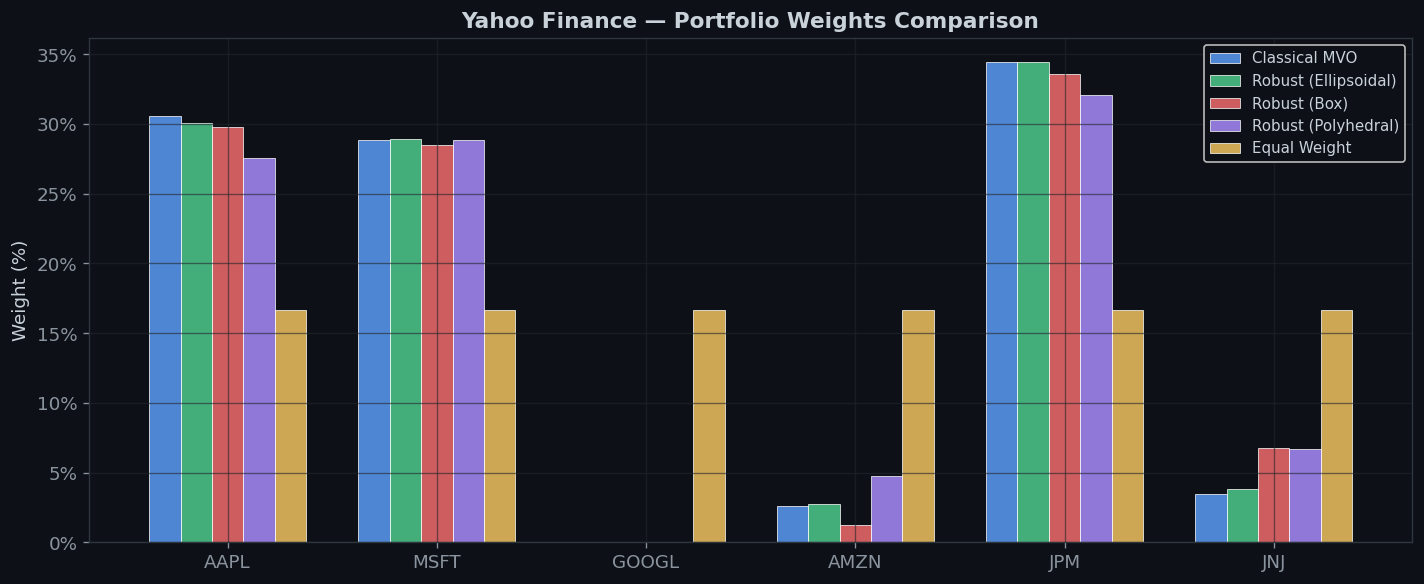

In [11]:
# ── Chart 5: YF Weights Comparison ──
fig, ax = plt.subplots(figsize=(12, 5))

x_yf = np.arange(n_yf)
width = 0.15

colors_yf = [C_BLUE, C_GREEN, C_RED, C_PURPLE, C_YELLOW]
labels_yf = ['Classical MVO', 'Robust (Ellipsoidal)', 'Robust (Box)', 'Robust (Polyhedral)', 'Equal Weight']
weights_yf_all = [w_mvo_yf, w_ell_yf, w_box_yf, w_poly_yf, w_eq_yf]

for j, (w, c, l) in enumerate(zip(weights_yf_all, colors_yf, labels_yf)):
    offset = (j - 2) * width
    ax.bar(x_yf + offset, w * 100, width, label=l, color=c, alpha=0.85,
           edgecolor='white', linewidth=0.5)

ax.set_ylabel('Weight (%)')
ax.set_title('Yahoo Finance — Portfolio Weights Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_yf)
ax.set_xticklabels(tickers)
ax.legend(loc='upper right', framealpha=0.9, fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
plt.tight_layout()
plt.show()

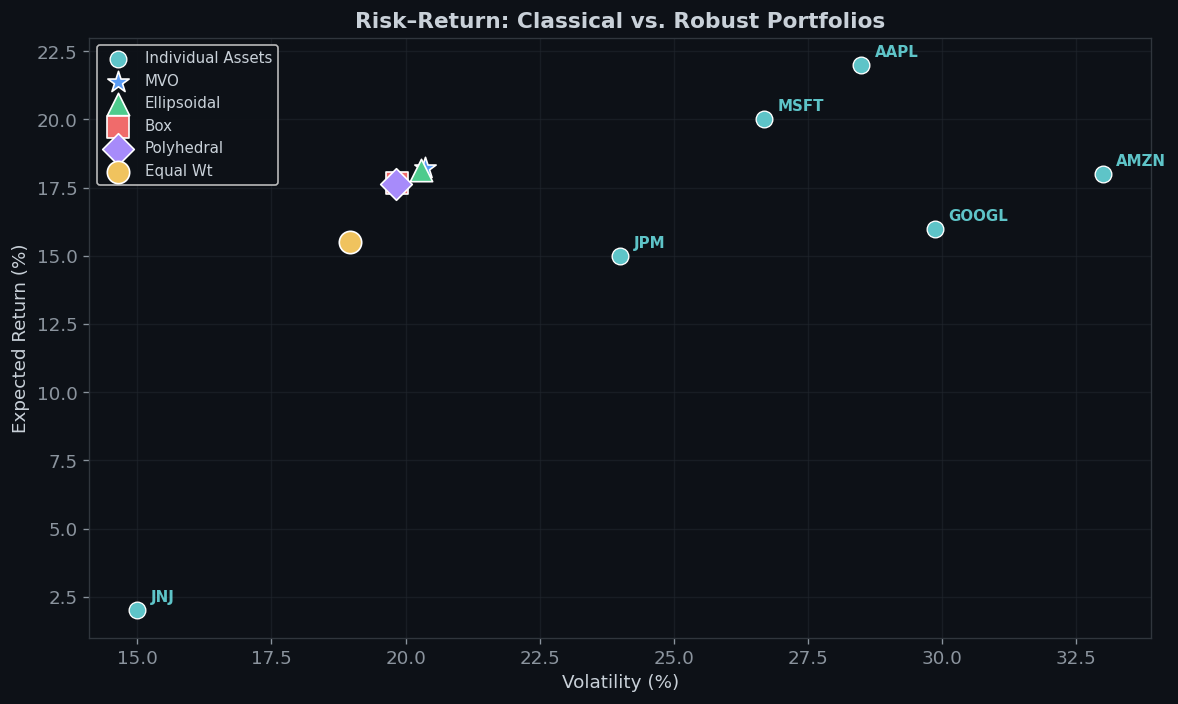

In [12]:
# ── Chart 6: Risk-Return Scatter (YF) ──
fig, ax = plt.subplots(figsize=(10, 6))

# Individual assets
asset_vols = [np.sqrt(Sigma_yf[i, i]) * 100 for i in range(n_yf)]
asset_rets = [mu_hat_yf[i] * 100 for i in range(n_yf)]

ax.scatter(asset_vols, asset_rets, s=100, c=C_TEAL, zorder=5,
           edgecolors='white', linewidth=0.8, label='Individual Assets')
for i, t in enumerate(tickers):
    ax.annotate(t, (asset_vols[i], asset_rets[i]),
                xytext=(8, 5), textcoords='offset points',
                fontsize=9, color=C_TEAL, fontweight='bold')

# Portfolio points
markers = ['*', '^', 's', 'D', 'o']
port_colors = [C_BLUE, C_GREEN, C_RED, C_PURPLE, C_YELLOW]
port_labels = ['MVO', 'Ellipsoidal', 'Box', 'Polyhedral', 'Equal Wt']
port_weights = [w_mvo_yf, w_ell_yf, w_box_yf, w_poly_yf, w_eq_yf]

for w, m, c, l in zip(port_weights, markers, port_colors, port_labels):
    r, v, _ = portfolio_metrics(w, mu_hat_yf, Sigma_yf)
    ax.scatter(v*100, r*100, s=180, c=c, marker=m, zorder=6,
               edgecolors='white', linewidth=1, label=l)

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Risk–Return: Classical vs. Robust Portfolios', fontsize=13, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=9)
plt.tight_layout()
plt.show()

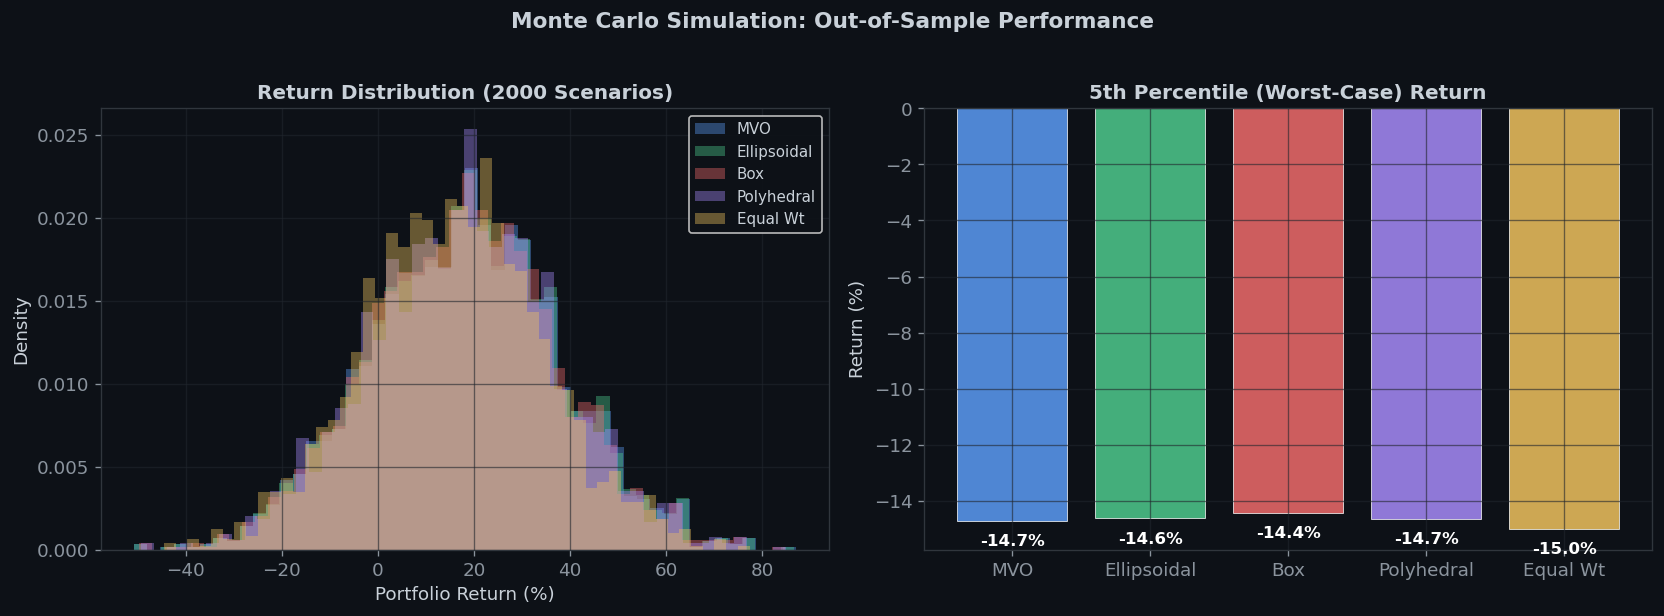

Monte Carlo Summary (2000 scenarios):
Portfolio          Mean   StdDev  5th pct  1st pct
----------------------------------------------
MVO               18.3%    20.0%   -14.7%   -26.7%
Ellipsoidal       18.2%    19.9%   -14.6%   -26.7%
Box               17.7%    19.4%   -14.4%   -26.2%
Polyhedral        17.7%    19.4%   -14.7%   -25.7%
Equal Wt          15.5%    18.7%   -15.0%   -28.8%


In [13]:
# ── Chart 7: Out-of-Sample Simulation ──
# Simulate 1000 "realized" return vectors drawn from the estimated distribution
# and compare portfolio performance across realizations

np.random.seed(42)
n_scenarios = 2000
realized_returns = np.random.multivariate_normal(mu_hat_yf, Sigma_yf, n_scenarios)

port_labels_sim = ['MVO', 'Ellipsoidal', 'Box', 'Polyhedral', 'Equal Wt']
port_weights_sim = [w_mvo_yf, w_ell_yf, w_box_yf, w_poly_yf, w_eq_yf]
port_colors_sim = [C_BLUE, C_GREEN, C_RED, C_PURPLE, C_YELLOW]

# Compute portfolio returns for each scenario
scenario_returns = {}
for label, w in zip(port_labels_sim, port_weights_sim):
    scenario_returns[label] = realized_returns @ w

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of returns
for label, c in zip(port_labels_sim, port_colors_sim):
    axes[0].hist(scenario_returns[label] * 100, bins=50, alpha=0.4, color=c,
                 label=label, density=True)

axes[0].set_xlabel('Portfolio Return (%)')
axes[0].set_ylabel('Density')
axes[0].set_title('Return Distribution (2000 Scenarios)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9, framealpha=0.9)

# Worst-case returns (5th percentile)
tail_pcts = []
for label in port_labels_sim:
    tail_pcts.append(np.percentile(scenario_returns[label], 5) * 100)

bars = axes[1].bar(port_labels_sim, tail_pcts, color=port_colors_sim, alpha=0.85,
                    edgecolor='white', linewidth=0.5)

for bar, val in zip(bars, tail_pcts):
    axes[1].annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, val),
                     xytext=(0, -15 if val < 0 else 5), textcoords='offset points',
                     ha='center', fontsize=10, fontweight='bold', color='white')

axes[1].set_ylabel('Return (%)')
axes[1].set_title('5th Percentile (Worst-Case) Return', fontsize=12, fontweight='bold')
axes[1].axhline(0, color='#30363d', linewidth=1, linestyle='--')

plt.suptitle('Monte Carlo Simulation: Out-of-Sample Performance',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print('Monte Carlo Summary (2000 scenarios):')
print(f'{"Portfolio":<14s} {"Mean":>8s} {"StdDev":>8s} {"5th pct":>8s} {"1st pct":>8s}')
print('-' * 46)
for label in port_labels_sim:
    sr = scenario_returns[label] * 100
    print(f'{label:<14s} {sr.mean():>7.1f}% {sr.std():>7.1f}% {np.percentile(sr,5):>7.1f}% {np.percentile(sr,1):>7.1f}%')

<a id='8'></a>
## 8. Comparison & Discussion

### Key Observations

From both the synthetic and real-data examples, several patterns emerge:

**Diversification effect:** All robust approaches produce more diversified portfolios than classical MVO. The concentration in high-return assets (like AAPL or EM Equity) is reduced because the robust penalty discounts the uncertain part of the return estimate.

**Box vs. Ellipsoidal vs. Polyhedral:** The box set is the most conservative — it pushes allocations furthest from MVO and closest to equal-weight. The ellipsoidal set provides a more nuanced adjustment because it accounts for correlations between estimation errors. The polyhedral set offers the most tunable trade-off via $\Gamma$.

**Tail-risk protection:** In the Monte Carlo simulation, robust portfolios consistently show better worst-case (5th percentile) performance than MVO, confirming the theoretical guarantee. The "insurance" is most valuable during adverse scenarios.

**κ sensitivity:** The weights smoothly transition from the MVO solution (at $\kappa = 0$) to an approximately equal-weight or minimum-variance portfolio (at large $\kappa$). This gives the investor a clear dial to control the robustness level.

### When to Use Robust Optimization

Robust optimization is most valuable when expected return estimates are unreliable (short history, structural breaks, or highly volatile assets), when the investor is particularly averse to worst-case outcomes, or when the number of assets is large relative to the available data, amplifying estimation error. It may be less useful when high-quality return forecasts are available and the investor wishes to exploit them aggressively.

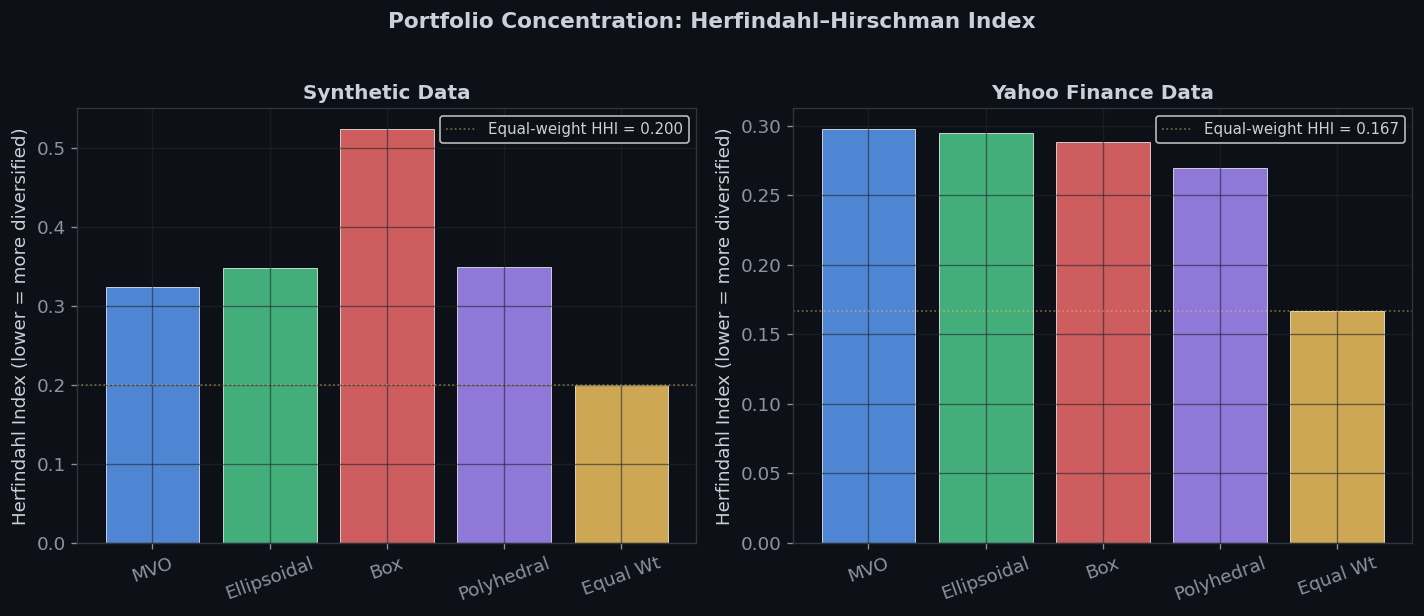

Lower HHI → more diversified portfolio.
Robust portfolios consistently have lower concentration than MVO.


In [14]:
# ── Chart 8: Herfindahl Index (Concentration) Comparison ──
def herfindahl(w):
    return np.sum(w ** 2)

hhi_labels = ['MVO', 'Ellipsoidal', 'Box', 'Polyhedral', 'Equal Wt']
hhi_synth = [herfindahl(w) for w in [w_mvo, w_ell, w_box, w_poly, w_eq]]
hhi_yf    = [herfindahl(w) for w in [w_mvo_yf, w_ell_yf, w_box_yf, w_poly_yf, w_eq_yf]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bar_colors = [C_BLUE, C_GREEN, C_RED, C_PURPLE, C_YELLOW]

axes[0].bar(hhi_labels, hhi_synth, color=bar_colors, alpha=0.85,
            edgecolor='white', linewidth=0.5)
axes[0].set_title('Synthetic Data', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Herfindahl Index (lower = more diversified)')
axes[0].tick_params(axis='x', rotation=20)

axes[1].bar(hhi_labels, hhi_yf, color=bar_colors, alpha=0.85,
            edgecolor='white', linewidth=0.5)
axes[1].set_title('Yahoo Finance Data', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Herfindahl Index (lower = more diversified)')
axes[1].tick_params(axis='x', rotation=20)

# Equal-weight reference line
for ax, n_a in zip(axes, [n, n_yf]):
    ax.axhline(1/n_a, color=C_YELLOW, linewidth=1, linestyle=':', alpha=0.5,
               label=f'Equal-weight HHI = {1/n_a:.3f}')
    ax.legend(fontsize=9, framealpha=0.9)

plt.suptitle('Portfolio Concentration: Herfindahl–Hirschman Index',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Lower HHI → more diversified portfolio.')
print('Robust portfolios consistently have lower concentration than MVO.')

<a id='9'></a>
## 9. References

**[1]** Goldfarb, D. and Iyengar, G. (2003). "Robust Portfolio Selection Problems." *Mathematics of Operations Research*, 28(1), pp. 1–38.

**[2]** Ben-Tal, A. and Nemirovski, A. (1998). "Robust Convex Optimization." *Mathematics of Operations Research*, 23(4), pp. 769–805.

**[3]** Ben-Tal, A. and Nemirovski, A. (1999). "Robust Solutions of Uncertain Linear Programs." *Operations Research Letters*, 25(1), pp. 1–13.

**[4]** Bertsimas, D. and Sim, M. (2004). "The Price of Robustness." *Operations Research*, 52(1), pp. 35–53.

**[5]** Tütüncü, R.H. and Koenig, M. (2004). "Robust Asset Allocation." *Annals of Operations Research*, 132, pp. 157–187.

**[6]** El Ghaoui, L., Oks, M. and Oustry, F. (2003). "Worst-Case Value-at-Risk and Robust Portfolio Optimization: A Conic Programming Approach." *Operations Research*, 51(4), pp. 543–556.

**[7]** Fabozzi, F., Kolm, P., Pachamanova, D. and Focardi, S. (2007). *Robust Portfolio Optimization and Management*. Hoboken: Wiley.

**[8]** Markowitz, H.M. (1952). "Portfolio Selection." *The Journal of Finance*, 7(1), pp. 77–91.

**[9]** Michaud, R.O. (1989). "The Markowitz Optimization Enigma: Is 'Optimized' Optimal?" *Financial Analysts Journal*, 45(1), pp. 31–42.

**[10]** Best, M.J. and Grauer, R.R. (1991). "On the Sensitivity of Mean-Variance-Efficient Portfolios to Changes in Asset Means." *The Review of Financial Studies*, 4(2), pp. 315–342.

**[11]** Bertsimas, D., Brown, D.B. and Caramanis, C. (2011). "Theory and Applications of Robust Optimization." *SIAM Review*, 53(3), pp. 464–501.

**[12]** Bertsimas, D., Gupta, V. and Paschalidis, I.Ch. (2012). "Inverse Optimization: A New Perspective on the Black-Litterman Model." *Operations Research*, 60(6), pp. 1389–1403.

**[13]** Erdoğan, E., Goldfarb, D. and Iyengar, G. (2004). "Robust Portfolio Management." *Manuscript*, Department of IEOR, Columbia University.

**[14]** Soyster, A.L. (1973). "Convex Programming with Set-Inclusive Constraints and Applications to Inexact Linear Programming." *Operations Research*, 21(5), pp. 1154–1157.

**[15]** Lu, Z. (2011). "Robust Portfolio Selection Based on a Joint Ellipsoidal Uncertainty Set." *Optimization Methods and Software*, 26(1), pp. 89–104.

**[16]** Fabozzi, F., Huang, D. and Zhou, G. (2010). "Robust Portfolios: Contributions from Operations Research and Finance." *Annals of Operations Research*, 176, pp. 191–220.

**[17]** Ledoit, O. and Wolf, M. (2004). "A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices." *Journal of Multivariate Analysis*, 88(2), pp. 365–411.

**[18]** Ben-Tal, A., El Ghaoui, L. and Nemirovski, A. (2009). *Robust Optimization*. Princeton University Press.

---